In [1]:
import numpy as np 
import pandas as pd
import json
import ast

from glob import glob
from tqdm import tqdm

import keras
import keras.backend as K
import keras_cv


import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import tensorflow_io as tfio


VER=1

print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

2024-06-10 20:52:38.612380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 20:52:38.612498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 20:52:38.795687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version = 2.15.0
Using 2 GPUs


In [2]:
cmap = mpl.cm.get_cmap('coolwarm')

/tmp/ipykernel_24/3764859085.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [3]:
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


In [4]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b0_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [5]:
CFG.num_classes

182

In [6]:
CFG.num_classes

182

In [7]:
BASE_PATH = '/kaggle/input/birdclef-2024'


In [8]:
df= pd.read_csv(f'{BASE_PATH}/train_metadata.csv')


In [9]:
df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...
24454,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/845747,zitcis1/XC845747.ogg
24455,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/845817,zitcis1/XC845817.ogg
24456,zitcis1,[],[''],51.1207,4.5607,Cisticola juncidis,Zitting Cisticola,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/856176,zitcis1/XC856176.ogg
24457,zitcis1,[],[''],41.5607,-8.4236,Cisticola juncidis,Zitting Cisticola,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/856723,zitcis1/XC856723.ogg


In [10]:
len(df)

24459

In [11]:
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC164848


In [12]:
xc_ids_index = {xc_id:i for i,xc_id in enumerate(df['xc_id'].values)}

In [13]:
'magrob' in (CFG.name2label).keys()

False

In [14]:
# CFG.name2label['asbfly']

In [15]:
# li = []
# for i in range(len(df)):
#     l = eval(df.iloc[i]['secondary_labels'])
#     for k in range(len(l)):
#         if l[k] not in CFG.name2label.keys():
#             continue
#         l[k] = (CFG.name2label[l[k]])
#     li.append(l)

In [16]:
df.xc_id.values.shape[0]

24459

In [17]:
df.target.values.shape[0]

24459

In [18]:
df['filepath'][0]

'/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg'

In [19]:
df.iloc[0].filename

'XC134896.ogg'

In [20]:
df.iloc[0].filename[:-4]

'XC134896'

In [21]:
all_specs = np.load('/kaggle/input/birdclef-spectogram-v1/all_specs.npy',allow_pickle=True).item()

In [22]:
all_specs['XC134896'].shape

(128, 384)

In [23]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Audio:


# Visualization:


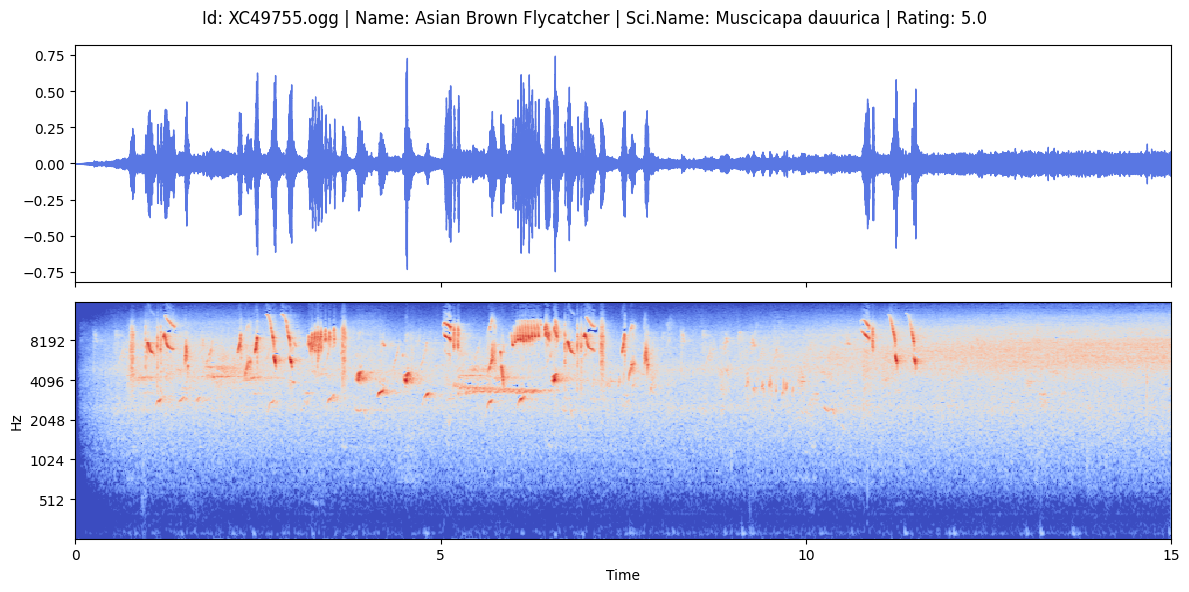

In [24]:
row = df.iloc[35]

# Display audio
display_audio(row)

In [25]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

In [26]:
# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
#     def get_audio(filepath):
#         file_bytes = tf.io.read_file(filepath)
#         audio = tfio.audio.decode_vorbis(file_bytes)  # decode .ogg file
#         audio = tf.cast(audio, tf.float32)
#         if tf.shape(audio)[1] > 1:  # stereo -> mono
#             audio = audio[..., 0:1]
#         audio = tf.squeeze(audio, axis=-1)
#         return audio

#     def crop_or_pad(audio, target_len, pad_mode="constant"):
#         audio_len = tf.shape(audio)[0]
#         diff_len = abs(
#             target_len - audio_len
#         )  # find difference between target and audio length
#         if audio_len < target_len:  # do padding if audio length is shorter
#             pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
#             pad2 = diff_len - pad1
#             audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
#         elif audio_len > target_len:  # do cropping if audio length is larger
#             idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
#             audio = audio[idx : (idx + target_len)]
#         return tf.reshape(audio, [target_len])

#     def apply_preproc(spec):
#         # Standardize
#         mean = tf.math.reduce_mean(spec)
#         std = tf.math.reduce_std(spec)
#         spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

#         # Normalize using Min-Max
#         min_val = tf.math.reduce_min(spec)
#         max_val = tf.math.reduce_max(spec)
#         spec = tf.where(
#             tf.math.equal(max_val - min_val, 0),
#             spec - min_val,
#             (spec - min_val) / (max_val - min_val),
#         )
#         return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(xc_id):
#         # Load audio file
#         audio = get_audio(path)
#         # Crop or pad audio to keep a fixed length
#         audio = crop_or_pad(audio, dim)
#         # Audio to Spectrogram
#         spec = keras.layers.MelSpectrogram(
#             num_mel_bins=CFG.img_size[0],
#             fft_length=CFG.nfft,
#             sequence_stride=CFG.hop_length,
#             sampling_rate=CFG.sample_rate,
#         )(audio)
#         # Apply normalization and standardization
#         spec = apply_preproc(spec)
#         # Spectrogram to 3 channel image (for imagenet)
        spec = all_specs[xc_id]
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(xc_id, label):
        label = get_target(label)
        return decode(xc_id), label

    return decode_with_labels if with_labels else decode

In [27]:
import albumentations as albu

In [28]:
import tensorflow_probability as tfp
def mixup(images, labels, alpha = 0.6):
    batch_size = tf.shape(images)[0]
    mix_weight = tfp.distributions.Beta(alpha, alpha).sample([batch_size, 1])
    mix_weight = tf.maximum(mix_weight, 1 - mix_weight)
    mix_weight1 = tf.expand_dims(mix_weight, axis=1)
    mix_weight1 = tf.stack([mix_weight1 for i in range(tf.shape(images)[-1])],axis = 3)
    images = mix_weight1 * images + (1 - mix_weight1) * tf.reverse(images, axis=[0])
    labels = mix_weight * labels + (1 - mix_weight) * tf.reverse(labels, axis=[0])
    return images, labels

In [29]:
def build_augmenter():
    augmenters = [
#         keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment

In [30]:
# def build_dataset(paths, labels=None, batch_size=32, 
#                   decode_fn=None, augment_fn=None, cache=True,
#                   augment=False, shuffle=False):

#     if decode_fn is None:
#         decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

#     if augment_fn is None:
#         augment_fn = build_augmenter()
        
#     AUTO = tf.data.experimental.AUTOTUNE
#     slices = (paths,) if labels is None else (paths, labels)
#     ds = tf.data.Dataset.from_tensor_slices(slices)

#     with_labels = labels is not None
    
#     def _map_fn(*args):
#         # Wrap decode_fn to ensure the conversion of tensors to numpy values
#         def _py_func(*py_args):
#             return tf.numpy_function(decode_fn, py_args, Tout=[tf.float32, tf.float32] if with_labels else tf.float32)

#         return tf.py_function(_py_func, args, [tf.float32, tf.float32] if with_labels else tf.float32)

#     ds = ds.map(_map_fn, num_parallel_calls=AUTO)
#     ds = ds.cache() if cache else ds
#     if shuffle:
#         opt = tf.data.Options()
#         ds = ds.shuffle(shuffle, seed=CFG.seed)
#         opt.experimental_deterministic = False
#         ds = ds.with_options(opt)
#     ds = ds.batch(batch_size, drop_remainder=True)
# #     ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
#     ds = ds.prefetch(AUTO)
#     return ds

In [31]:
class build_dataset(tf.keras.utils.Sequence):
    def __init__(self,xc_ids, labels=None, batch_size=32, 
                  decode_fn=None, augment_fn=None,
                  augment=True, shuffle=True):
        self.xc_ids = xc_ids
        self.labels = labels
        self.batch_size = batch_size 
        self.decode_fn = decode_fn
        self.augment_fn = augment_fn
        self.augment = augment 
        self.shuffle = shuffle 
        
        if self.decode_fn is None:
            self.decode_fn = build_decoder(self.labels is not None, dim=CFG.audio_len)

        if self.augment_fn is None:
            self.augment_fn = build_augmenter()
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil((self.xc_ids).shape[0] / self.batch_size ) )
        return ct
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X,y = self.__augment_batch(X,y) 
        return X, y
    
    def __data_generation(self,indexes):
        X = np.zeros((len(indexes),128,384,3),dtype='float32')
        y = np.zeros((len(indexes),CFG.num_classes),dtype='float32')
        
        img = np.ones((128,384),dtype='float32')
        
        for j,i in enumerate(indexes):
            xc_id = self.xc_ids[i]
            X[j,:,:,],y[j,:] = self.decode_fn(xc_id,self.labels[i])
#             l = ast.literal_eval((df.iloc[xc_ids_index[xc_id]]['secondary_labels']))
# #             print(type(l))
#             for k in range(len(l)):
#                 if l[k] not in CFG.name2label.keys():
#                     continue
#                 l[k] = (CFG.name2label[l[k]])
#                 y[j,l[k]] = 0
         
        return X,y
    
    def __augment_batch(self, img_batch,y):
        img_batch,y = self.augment_fn(img_batch,y)
        img_batch,y = mixup(img_batch,y)
            
        return img_batch,y
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange((self.xc_ids).shape[0])
        if self.shuffle: np.random.shuffle(self.indexes)

In [32]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
        print(specs.shape)
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            try :
                label = tars[idx].numpy().argmax()
            except :
                label = tars[idx].argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

In [33]:
# df.xc_id.values

In [34]:
sample_ds = build_dataset(df.xc_id.values, df.target.values, batch_size=CFG.batch_size, augment=CFG.augment)

In [35]:
sample_ds

(32, 128, 384, 3)


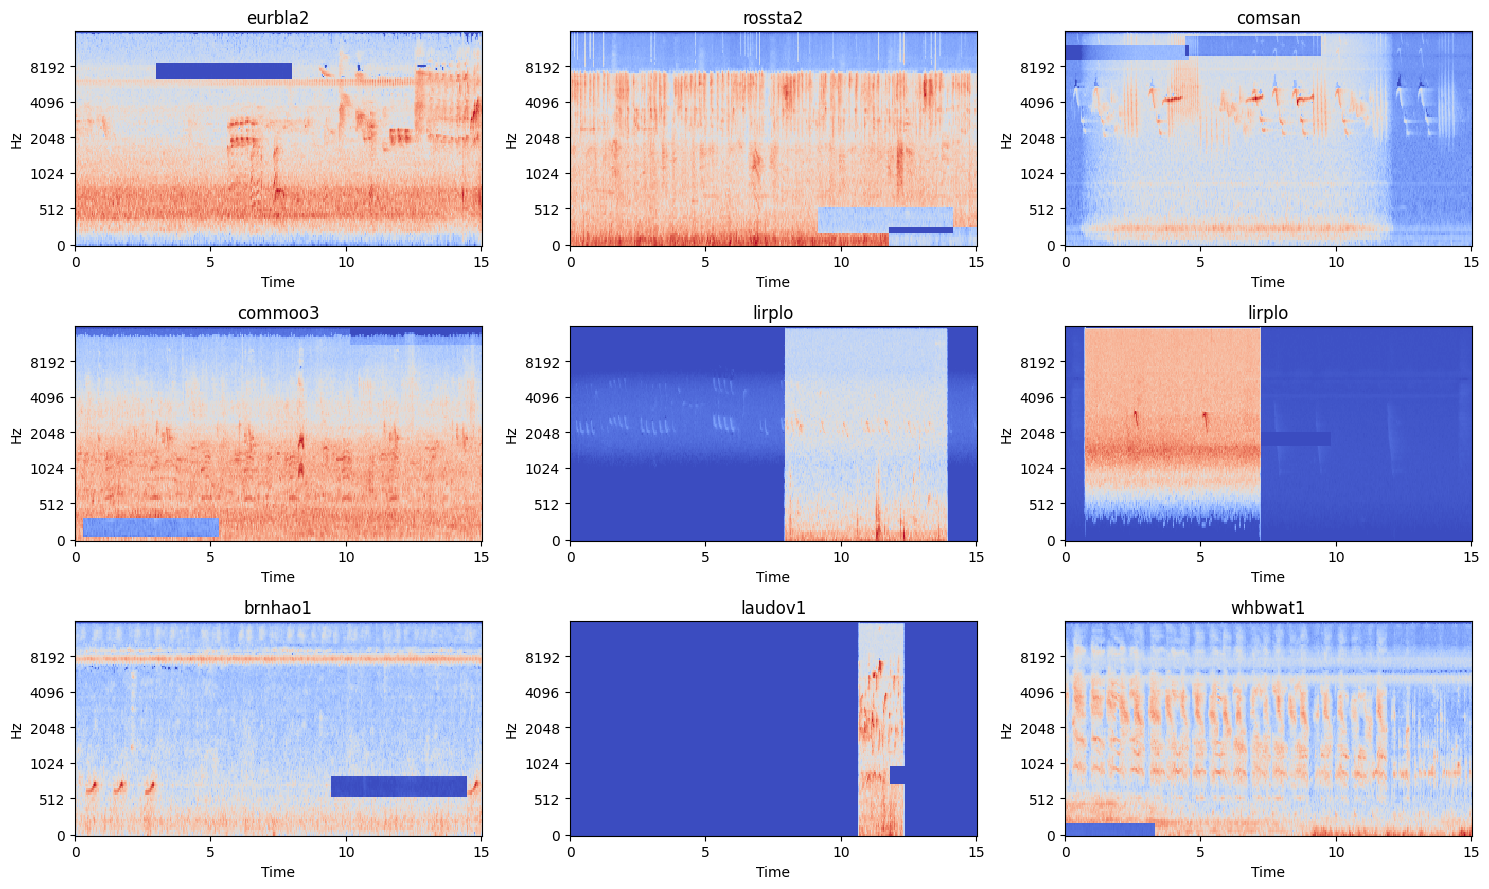

In [36]:
# sample_ds = sample_ds.take(100)
# batch = next(iter(sample_ds))
plot_batch(sample_ds[0], label2name=CFG.label2name)

In [37]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)


In [38]:
def custom_loss(y_true,y_pred):
    
    loss1 = tf.keras.losses.CategoricalCrossentropy()(y_true,y_pred)
    loss2 = tf.keras.losses.BinaryCrossentropy()(y_true,y_pred)
    print(loss1,loss2)
    
    return ((loss1+loss2)/2)

In [39]:
def add_regularization(model, regularizer = tf.keras.regularizers.l2(0.0001)):
    """
    Helper function to add l2 regularisation to each layer of a either a preTrained or 
    randomly initialised built in model
    Arguments:
        model : (keras.model) input model 
        regularizer : ( tf.keras.regularizers.l2) object from keras that defines a l2 regularizer
    Returns:
        model : all layers contain the "regularizer" object & incase we pass a pretrained model then the 
                original weights are preserved
    """

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join('/kaggle/working/', 'tmp_weights.weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path)
    return model

In [40]:
import efficientnet.tfkeras as efn

def build_model1():
    
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(128,384,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    l2_penalty = 10e-6
    regularizer = tf.keras.regularizers.l2(l2_penalty)
    reg_base_model = add_regularization(base_model,regularizer)
    reg_base_model.trainable = True

    # Joining the entire pipeline using functional API
    inputs = tf.keras.Input((128,384, 3))
    h = reg_base_model(inputs, training=True)
    h = tf.keras.layers.GlobalAveragePooling2D()(h)
    
    # Non linear projection layer to improve the quality of embeddings being produced
    projection_1 = tf.keras.layers.Dense(256, kernel_regularizer = regularizer)(h)
    projection_1 = tf.keras.layers.BatchNormalization()(projection_1)
    projection_1 = tf.keras.layers.Activation("relu")(projection_1)
    projection_2 = tf.keras.layers.Dense(256, kernel_regularizer = regularizer)(projection_1)
    projection_2 = tf.keras.layers.BatchNormalization()(projection_2)
    projection_2 = tf.keras.layers.Activation("relu")(projection_2)
    
    final_model = tf.keras.Model(inputs, projection_2)
    return final_model

In [41]:
model1 = build_model1()
model1.load_weights('/kaggle/input/bird-clef-pretraining/pretraining_on_unlabeled (1).h5')
efficientnet_weights = model1.get_layer('efficientnet-b0').get_weights()

In [42]:
import efficientnet.tfkeras as efn

def build_model():
    
    inp = tf.keras.Input(shape=(None,None,3))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    base_model.set_weights(efficientnet_weights)
#     base_model.trainable = False  
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(1280)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dense(CFG.num_classes,activation='sigmoid', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss=tf.keras.losses.CategoricalCrossentropy()
#     loss = tf.keras.losses.BinaryCrossentropy()
#     loss = custom_loss
    metrics=[tf.keras.metrics.AUC(name='auc',multi_label=True,num_labels=CFG.num_classes),tf.keras.metrics.F1Score(threshold=0.5,average="macro"),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives()]
    model.compile(loss=loss, optimizer = opt,metrics=metrics) 
        
    return model

In [43]:
model=build_model()

In [44]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b0 (Functional)    │ (None, None, None,     │     4,049,564 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 182)            │       233,142 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,282,706 (16.34 MB)

 Trainable params: 4,240,690 (16.18 MB)

 Non-trainable params: 42,016 (164.12 KB)

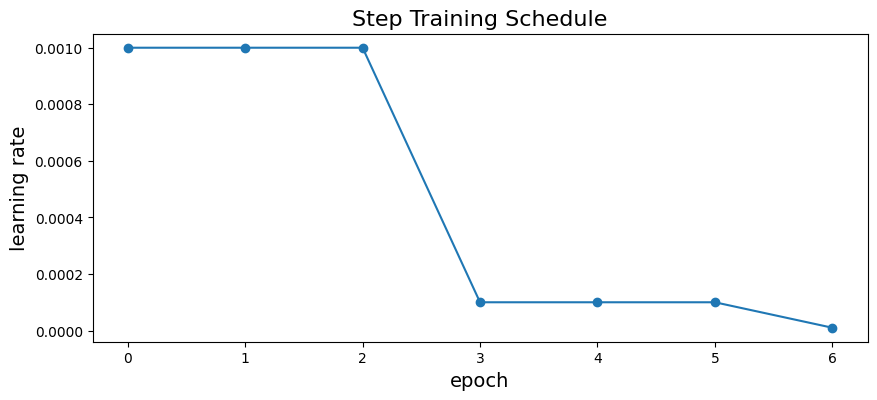

In [45]:
EVERY = 1
EPOCHS = 7

def lrfn(epoch):
    a=[0.001,0.001,0.001,0.0001,0.0001,0.0001,0.00001]
    return a[epoch]

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [46]:
from sklearn.model_selection import KFold, GroupKFold,StratifiedKFold
import tensorflow.keras.backend as K, gc
from sklearn.utils import shuffle

all_oof = []
all_true = []

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for i, (train_index, valid_index) in enumerate(skf.split(df, df.target)):  
#     if(i==0 or i==1 or i==2):
#         continue 
    print('#'*25)
    print(f'### Fold {i+1}')
    
    temp_df = shuffle(df.iloc[train_index])
    train_gen = build_dataset(temp_df.xc_id.values,temp_df.target.values, batch_size=CFG.batch_size, augment=CFG.augment)
    valid_gen = build_dataset(df.iloc[valid_index].xc_id.values,df.iloc[valid_index].target.values, shuffle=False, batch_size=CFG.batch_size, augment=False)
    print(f'### train size {len(df.iloc[train_index])}, valid size {len(df.iloc[valid_index])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR])
        model.save_weights(f'EffNet_v{VER}_f{i}.weights.h5')
#         model.load_weights(f'/kaggle/input/bird-clef-effnet-v1/EffNet_v1_f{i}.weights.h5')
    
    oof = []
    true = []
    for x,y in valid_gen:
        if(x.shape[0] == 0):
            break
        temp = model.predict(x, verbose=0)
        oof.append(temp)
        true.append(y)
    oof = np.concatenate(oof)
    true = np.concatenate(true)
    all_oof.append(oof)
#     all_true.append(df.iloc[valid_index].target.values)
    all_true.append(true)
    
    
    del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 19567, valid size 4892
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/7


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


612/612 ━━━━━━━━━━━━━━━━━━━━ 328s 322ms/step - auc: 0.5640 - f1_score: 0.0198 - false_negatives: 5305.5977 - false_positives: 121030.7266 - loss: 4.4537 - val_auc: 0.7280 - val_f1_score: 0.0613 - val_false_negatives: 455.0000 - val_false_positives: 41357.0000 - val_loss: 2.8672 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/7
612/612 ━━━━━━━━━━━━━━━━━━━━ 191s 310ms/step - auc: 0.6941 - f1_score: 0.0435 - false_negatives: 4134.2290 - false_positives: 96248.4922 - loss: 3.1602 - val_auc: 0.7550 - val_f1_score: 0.0487 - val_false_negatives: 255.0000 - val_false_positives: 60590.0000 - val_loss: 2.2382 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/7
612/612 ━━━━━━━━━━━━━━━━━━━━ 190s 308ms/step - auc: 0.7339 - f1_score: 0.0520 - false_negatives: 3839.7830 - false_positives: 91735.1953 - loss: 2.7937 - val_auc: 0.7474 - val_f1_score: 0.0882 - val_false_negatives: 393.0000 - val_false_positives:

In [47]:
all_oof.shape

(24459, 182)

In [48]:
all_true.shape

(24459, 182)

In [49]:
# all_oof[0]

In [50]:
all_true[all_true != 0] = 1

In [51]:
# all_true[0]

In [52]:
import sys
sys.path.append('/kaggle/input/birdclef-roc-auc')
sys.path.append('/kaggle/usr/lib/kaggle_metric_utilities')
from metric import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(true,oof, row_id_column_name='id')
print('CV Score ROC_AUC for EfficientNetB0 =',cv)

CV Score ROC_AUC for EfficientNetB0 = 0.9501048563193971
